<h1 align="center"> TP3 : Linear Elastic Fracture Mechanics </h1>
<h2 align="center"> Jeremy Bleyer </h2>

> **Objectives**:
> * Run linear elastic finite-element analyses of cracked structures
> * Study asymptotic fields near the crack tip
> * Estimate stress intensity factors and energy release rate with various techniques (asymptotics, potential energy variation, $J$-integral, $G-\theta$ method) 

## Problem position

### Geometry


<img src="pic/SENB_geometry.svg" alt="SENB" width="600" align="middle">

We consider the problem of a single-edge notched beam in bending (SENB). It consists of a beam of span $2L$ and height $H$, simply supported on two roller-pinned supports and loaded by a concentrated vertical load at the top at its center. A vertical pre-crack is inserted from the bottom face at its center in the form of an initial notch of width $2e$ and height $h$. For symmetry reasons, we model only the right-half of the specimen.

Here, we do not model crack propagation but analyze the mechanical fields for a given crack location. The crack is therefore modelled explicitly by releasing nodes of the vertical boundary. The crack extent from the pre-notch tip is denoted by $a$, the total crack length from the bottom face being then $\ell = a + h$.


The `SENB_geometry.py` file generates a `GMSH` (http://gmsh.info) model and returns the corresponding mesh for FEniCSx along with the corresponding boundary markers:
* 1 : for the roller support
* 2 : for the loading region
* 3 : ahead of the crack tip on the vertical symmetry plane
* 4 : the crack on the vertical symmetry plane
* 5-6-7 : contours for the $J$-integral computations


<img src="pic/SENB_model.svg" alt="SENB - Gmsh model" width="600" align="middle">

### Material

The material is linear elastic with $E=3$ GPa and $\nu=0.33$. The computations are done in **plane stress** conditions.

## Implementation

We start by importing the relevant modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ufl
from ufl import sym, grad, tr, Identity, inner
from dolfinx import fem
from mealor import DirichletBoundaryCondition
from mealor.plotting import plot_mesh, plot_def
from mealor.utils import integrate, plot_over_line, save_to_file, interpolate_expr
from SENB_geometry import generate_SENB
from energy_release_rate import compute_J_integral, compute_G_theta

Now let us define the geometrical parameters. `coarse_size` denotes the mesh size away from the crack tip. Around the crack_tip, the mesh_size is reduced by a factor `refinement_ratio`.

In [2]:
# SENB geometry parameters
L = 20.0
H = 10.0
notch = 0.4 * H
e = notch / 20
s = e
coarse_size = 2 * e
refinement_ratio = 20

# Material parameters
E = 3e3
nu = 0.33

# loading amplitude
F = 1.0

We generate and plot the mesh corresponding to the case $a = 0.1H$ ($\ell=0.5H$).

In [3]:
a = 0.1*H
mesh_data = generate_SENB(L, H, notch, a, e, s, coarse_size, coarse_size / refinement_ratio)
domain, cell_markers, facet_markers = mesh_data
plot_mesh(domain)

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, orientation_widget=True, sizing_mode='stretch_width')

We now define a function to set up the variational formulation of the elastic problem, solve it and retrieve the solution

In [4]:
def epsilon(v):
    return sym(grad(v))

def get_measures(mesh_data):
    dx = ufl.Measure("dx", domain=domain, subdomain_data=cell_markers)
    ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_markers)
    dS = ufl.Measure("dS", domain=domain, subdomain_data=facet_markers)
    return (dx, ds, dS)

def solve_elastic_problem(domain, measures, degree=2):
    dx, ds, dS = measures
    V = fem.VectorFunctionSpace(domain, ("CG", degree))
    
    u = fem.Function(V, name="Displacement")

    lmbda = fem.Constant(domain, E * nu / (1 + nu) / (1 - 2 * nu))
    mu = fem.Constant(domain, E / 2 / (1 + nu))
    lmbda_ps = (
        2 * mu * lmbda / (lmbda + 2 * mu)
    )  # effective lambda modulus for plane stress

    def sigma(v):
        return lmbda_ps * tr(epsilon(v)) * Identity(2) + 2 * mu * epsilon(v)

    u_ = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    load = fem.Constant(domain, np.array([0, -F / 2 / s]))

    a_el = inner(sigma(u_), epsilon(v)) * dx
    L_el = inner(load, v) * ds(2)

    dirichlet = DirichletBoundaryCondition(V)
    dirichlet.add_bc_topological(facet_markers, 1, uy=0)
    dirichlet.add_bc_topological(facet_markers, 3, ux=0)

    # Linear problem setup and solve
    problem = fem.petsc.LinearProblem(
        a_el,
        L_el,
        u=u,
        bcs=dirichlet.bcs,
        petsc_options={"ksp_type": "preonly", "pc_type": "lu"},
    )
    problem.solve()

    # Stress (UFL expression, not in a FE function space)
    sig = sigma(u)

    ## Output fields
    save_to_file("linear_elasticity", u)
    # need to interpolate sig on a function space for output
    V_sig = fem.TensorFunctionSpace(domain, ("DG", degree - 1))
    sig_interp = interpolate_expr(sig, V_sig, name="Stress")
    save_to_file("linear_elasticity", sig_interp)

    # Potential energy of the solution
    energy = 2 * (-0.5 * integrate(ufl.action(L_el, u)))

    return u, sig, energy

Let's solve our first problem.

In [5]:
measures = get_measures(mesh_data)
u, sig, energy = solve_elastic_problem(domain, measures)

plot_def(u, scale=100.)

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='4f5...], orientation_widget=True, sizing_mode='stretch_width')

## Asymptotic field analysis

Now we want to analyze the asymptotic mechanical fields near the crack tip. To do so, we use the `plot_over_line` function which retrieves values of a given field on a line `[pA, pB]` between two points `pA` and `pB`.

### Crack-opening displacement

**Q1.** What can you say about the crack opening displacement ? Is it behaving as expected ? We suggest defining a variable `r` as the distance from the crack tip and plot the fields against `r`.

**Q2.** Give an estimate of the stress intensity factor SIF from the crack-opening displacement asymptotic behaviour. We suggest plotting the quantity corresponding to the SIF as a function of `r`. Is this method robust ?


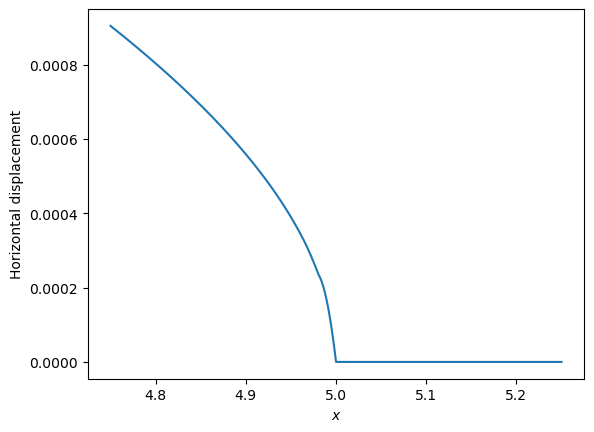

In [6]:
ell = a + notch
pA = (0, 0.95*ell)
pB = (0, 1.05*ell)
u_x, points = plot_over_line(u.sub(0), [pA, pB], domain)

plt.figure()
plt.plot(points[:, 1], u_x, "-")
plt.xlabel(r"$x$")
plt.ylabel("Horizontal displacement")
plt.show()

### Stress field

**Q3.** Do a similar study for the stress field. Is the stress field varying as expected around the crack tip ? What is the mode mixity for this crack ?
> You can access the `i,j` component of the stress using `sig[i,j]` for `i,j=0,1` corresponding respectively to $x,y$.

## Energy release rate computations

In this part, we would like to explore more robust ways of measuring SIF or, equivalently using Irwin's formula, energy release rates (ERR) using various methods.

### Potential energy variation

 We will first use the variation of the potential energy as a function of the crack variation. To compute it around the value $a_0=0.1$, let us loop over a list of crack length values $a$ around $a_0$ and analyze the variation of the potential energy. Note that we must generate a new mesh for each value of $a$.


In [12]:
a0 = 0.1 * H
a_list = np.linspace(0.8 * a0, 1.2 * a0, 10)

E_pot = np.zeros_like(a_list)
G_J_integral = np.zeros_like(a_list)
for i, a in enumerate(a_list):
    mesh_data = generate_SENB(L, H, notch, a, e, s, coarse_size, coarse_size / refinement_ratio)
    domain, cell_markers, facet_markers = mesh_data
    measures = get_measures(mesh_data)

    u, sig, energy = solve_elastic_problem(domain, measures)

    w = 1/2*inner(sig, epsilon(u))
    Eshelby = w*Identity(2) - grad(u).T * sig
    G_J_integral[i] = compute_J_integral(Eshelby, measures)
    
    print(f"Crack length a={a:.3f}   Potential energy E_pot={energy:.5f}")
    
    E_pot[i] = energy

Crack length a=0.800   Potential energy E_pot=-0.00903
Crack length a=0.844   Potential energy E_pot=-0.00918
Crack length a=0.889   Potential energy E_pot=-0.00932
Crack length a=0.933   Potential energy E_pot=-0.00948
Crack length a=0.978   Potential energy E_pot=-0.00964
Crack length a=1.022   Potential energy E_pot=-0.00980
Crack length a=1.067   Potential energy E_pot=-0.00996
Crack length a=1.111   Potential energy E_pot=-0.01014
Crack length a=1.156   Potential energy E_pot=-0.01031
Crack length a=1.200   Potential energy E_pot=-0.01049


 **Q4.** Plot the variation of the potential energy as a function of $a$. Compute and plot the variation of the ERR as a function of $a$. Give an estimate of the ERR and the corresponding SIF.

 **Q5.**  What can you say about the characteristics of the crack propagation ? Fix the roller supports to block any horizontal motion and discuss again the crack propagation characteristics.

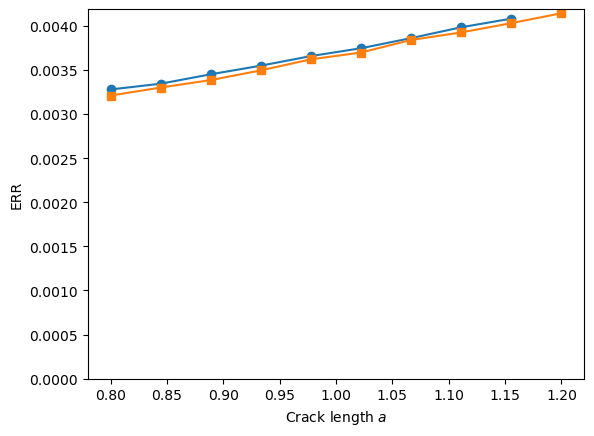

In [14]:
ERR = -np.diff(E_pot) / np.diff(a_list)
plt.figure()
plt.plot(a_list[0:-1], ERR, "o-", label=r"$\frac{d E_{pot}}{da}$")
plt.plot(a_list, 2*G_J_integral, "s-")
plt.ylim(0)
plt.xlabel("Crack length $a$")
plt.ylabel("ERR")
plt.show()

### $J$-integral

Now, we would like to compute the ERR using the $J$-integral.

**Q6.** Write the $J$-integral as a function of the Eshelby tensor defined by:
$$E_{ij} = w \delta_{ij} − u_{k,i}\sigma_{kj} \quad \text{with}\:\: w=\dfrac{1}{2}\boldsymbol{\sigma}:\boldsymbol{\varepsilon(\boldsymbol{u})}$$
Inside the above loop, compute the Eshelby tensor from `u` and `sigma`. Express it first in intrinsic notation. You can use `*` for the single contraction product between two tensors and `A.T` for transposing a tensor `A`.

> SOL: For a crack propagating in the direction $\boldsymbol{t}$, the $J$-integral writes:
> $$J = \int_{\Gamma} \boldsymbol{t}\cdot\boldsymbol{E}\cdot\boldsymbol{n} \,\text{d}S$$

**Q7.** Complete the function `compute_J_integral` which takes as an input the Eshelby tensor and the integration measures. We suggest to decompose the integral into 3 different contribution using the integration measure `dS` on interior facets and use the vectors `ex` and `ey` appropriately. Use the function `integrate` to compute the numerical value of your symbolic integral expression.

**Q8.** Run the loop and compare with the previous ERR estimates. Check that the $J$-integral does not strongly depend on the chosen contour by changing the optional argument `rJ` in ` generate_SENB` (`rJ=5*e` by default.)

### $G-\theta$ method

Finally, we would like to implement the $G-\theta$ method to compute the ERR without relying on computing facet quantities on internal contours as in the $J$-integral method. We recall that the ERR for a crack propagating in direction $\vec{t}$ can be obtained from the Eshelby tensor as follows:
$$ G = -\int_{\Omega} \theta_{i,j}E_{ij}\,\text{d}\Omega$$
where $\vec{\theta}$ is a continuous vectorial field with value $\vec{t}$ in a region around the crack tip and zero around an interior contour.

**Q9.** Such a vectorial field `theta` has already been defined in the function `compute_G_theta`. It linearly decreases as a function of $r$, the distance to the crack tip, between an internal disk of radius `r_int` towards an external disk of radius `r_ext`. Note that `r_ext` must not intersect the external boundary. Complete the function to compute the ERR (we recall that in UFL `inner(A, B)`$=A_{ij}B_{ij}$).

**Q10.** Run the loop and compare with the previous ERR estimates. Check that the $G-\theta$ method does not strongly depend on the chosen $\theta$ field.

**Q11.** To further verify your results, we provide below an analytical estimate of the SIF obtained from the ASTM standards [1]. 
$$
K_I(\ell) = \dfrac{3F(2L)}{H^{3/2}}\sqrt{\dfrac{\ell}{H}}\dfrac{1.99-\dfrac{\ell}{H}\left(1-\dfrac{\ell}{H}\right)\left(2.15-3.93\dfrac{\ell}{H} +2.7\left(\dfrac{\ell}{H}\right)^2 \right)}{2\left(1+2\dfrac{\ell}{H}\right)\left(1-\dfrac{\ell}{H}\right)^{3/2}}
$$
Check that your computed SIF compare well against the standards around a wide range of values of crack length, for instance for a from $0.01H$ to $0.5H$.

In [8]:
def K_ASTM(ell):
    x = ell/H
    return (3*F*2*L/ H**1.5)*(
            np.sqrt(x)
            * (1.99 - x * (1 - x) * (2.15 - 3.93 * x + 2.7 * x**2))
            / (2 * (1 + 2 * x) * (1 - x) ** 1.5)
        )
    